# Predicting Stock Movement Using Sentiment Analysis of Twitter Feed with SVM, Logistic Regression, and Decision Trees

- baseline: https://www.scirp.org/journal/paperinformation.aspx?paperid=104142#ref9
- sentiment kaggle: https://www.kaggle.com/datasets/kazanova/sentiment140 

# Sentiment 140 Data
For the training data, we are going to use a sentiment tagged Twitter dataset of 1.6 million tweets, collected from Sentiment140 for sentiment classification. The tweets are tagged ‘1’ and ‘0’ for being ‘positive’ and ‘negative’ respectively.

It contains the following 6 fields:

1. **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

2. **ids**: The id of the tweet ( 2087)

3. **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

4. **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.

5. **user**: the user that tweeted (robotickilldozr)

6. **text**: the text of the tweet (Lyx is cool)

Citation: Go, A., Bhayani, R. and Huang, L., 2009. Twitter sentiment classification using distant supervision. CS224N Project Report, Stanford, 1(2009), p.12.

### Download the data
Download from the Kaggle website and then save to your local directory. 

Kaggle: https://www.kaggle.com/datasets/kazanova/sentiment140


### Import packages

In [336]:
# utilities
import string 
import re 
import pickle # not used
import pandas as pd 
import time
import numpy as np
import matplotlib.pyplot as plt

In [337]:
# nltk
import nltk 
nltk.download('stopwords')
nltk.download('punkt') 
nltk.download('wordnet') 
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /Users/didi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/didi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/didi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [338]:
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


### Load in data

In [339]:
# import drive so you can access your folders
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# read in data
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin')

# add in the column names
df.columns = ['sentiment', 'tweet_id', 'time', 'flag', 'user', 'tweet']
df.head()


,sentiment,tweet_id,time,flag,user,tweet
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
# create a new dataframe with only tweets and sentiment
features ='tweet'
target = 'sentiment'

df = df[[features, target]]
df.head()

,tweet,sentiment
0,is upset that he can't update his Facebook by ...,0
1,@Kenichan I dived many times for the ball. Man...,0
2,my whole body feels itchy and like its on fire,0
3,"@nationwideclass no, it's not behaving at all....",0
4,@Kwesidei not the whole crew,0


### Data preprocessing

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   tweet      1599999 non-null  object
 1   sentiment  1599999 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [ ]:
# downcast to smaller integer size to reduce memory: int64 -> int8
df['sentiment'] = pd.to_numeric(df['sentiment'], downcast='integer')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   tweet      1599999 non-null  object
 1   sentiment  1599999 non-null  int8  
dtypes: int8(1), object(1)
memory usage: 13.7+ MB


In [ ]:
# find all sentiment values in the dataset 
df.sentiment.unique()

array([0, 4])

In [ ]:
# change 4 to 1 (positive)
df['sentiment'] = df['sentiment'].replace(4, 1)
df['sentiment'].value_counts()

1    800000
0    799999
Name: sentiment, dtype: int64

In [ ]:
class TweetCleaner:
  def __init__(self):
    self.stop_words = set(stopwords.words('english'))
    self.emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':(': 'sad', 'XD': 'laughing',
          ':-(': 'sad', ':-<': 'sad', ':P': 'stuck-out-tongue', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          ':/': 'confused', ':|': 'neutral-face', ":'-)": 'sadsmile', "<3": 'love',
          ":'-)": 'tears-of-happiness'}

  def lowercase(self, tweet):
    ''' Each text is converted to lowercase. '''
    return tweet.lower()
  
  def replace_url(self, tweet):
    ''' Links starting with “Http” or “https” or “www” are replaced by “URL” '''
    url_regex = re.compile(r'(http[s]?://|www\.)\S+')
    return url_regex.sub('URL', tweet)

  def replace_emojis(self, tweet):
    '''Replace emojis by using a pre-defined dictionary containing emojis 
      along with their meaning. (e.g.: “:)” to “EMOJIsmile”) '''
    for emoji in self.emojis.keys():
      tweet = tweet.replace(emoji, "EMOJI" + self.emojis[emoji]) 
    return tweet

  def replace_username(self, tweet):
    ''' Replace @Usernames with the word “USER”. (e.g.: “@Kaggle” to “USER”)'''
    user_regex = re.compile(r'@[^\s]+')
    return user_regex.sub('USER', tweet)  

  def remove_nonalpha(self, tweet):
    ''' Replacing characters except Digits and Alphabets with space.'''
    nonalpha_regex = re.compile(r'[^a-zA-Z0-9]')
    return nonalpha_regex.sub(" ", tweet)
  
  def remove_consecutives(self, tweet):
    ''' 3 or more consecutive letters are 
        replaced by two letters. (e.g.: “Heyyyy” to “Heyy”) '''
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    return re.sub(sequencePattern, seqReplacePattern, tweet)

  def remove_stop_short_words(self, tweet):
    ''' English words that do not add much meaning to a sentence are removed
        and Words with a length of less than two are eliminated.'''
    words = nltk.word_tokenize(tweet)
    words = [word for word in words if word not in self.stop_words and len(word) >= 2]
    return ' '.join(words)

  def lemmatize(self, tweet):
    ''' Converting word to its base form. '''
    tweetwords = ''
    for word in tweet.split():
      word = WordNetLemmatizer().lemmatize(word)
      tweetwords += (word+' ')
    return tweetwords

  def clean_onetweet(self, tweet):
    ''' cleans one single tweet '''
    cleaned = self.lowercase(tweet)
    cleaned = self.replace_url(cleaned)
    cleaned = self.replace_emojis(cleaned)
    cleaned = self.replace_username(cleaned)
    cleaned = self.remove_nonalpha(cleaned)
    cleaned = self.remove_consecutives(cleaned)
    cleaned = self.remove_stop_short_words(cleaned)
    cleaned = self.lemmatize(cleaned)
    return cleaned

  def clean_alltweets(self, df):
    ''' cleans all tweets in the dataframe'''
    df['tweets_processed'] = df['tweet'].apply(self.clean_onetweet)
    df = df.drop(columns=['tweet'])
    df = df.rename(columns={'tweets_processed': 'tweet'})
    return df


In [ ]:
# testing one tweet
tweet = "@jane and her Dogs have g !$MONEY sitting with https://www.mlq.ai/ai-companies-trading-investing/ babies with feet"
tweetCleaner = TweetCleaner()

print(tweetCleaner.clean_onetweet(tweet))

USER dog money sitting URL baby foot 


In [ ]:
# method for processing tweets
def process_tweet_dataframe(df):
  tweetCleaner = TweetCleaner()
  
  t = time.time()
  df_processed = tweetCleaner.clean_alltweets(df)
  print(f'Text Preprocessing complete.')
  print(f'Time Taken: {round(time.time()-t)} seconds')
  return df_processed

In [ ]:
df_processed = process_tweet_dataframe(df)

Text Preprocessing complete.
Time Taken: 182 seconds


In [ ]:
# view processed dataset
df.head()

,tweet,sentiment,tweets_processed
0,is upset that he can't update his Facebook by ...,0,upset update facebook texting might cry result...
1,@Kenichan I dived many times for the ball. Man...,0,USER dived many time ball managed save 50 rest...
2,my whole body feels itchy and like its on fire,0,whole body feel itchy like fire
3,"@nationwideclass no, it's not behaving at all....",0,USER behaving mad see
4,@Kwesidei not the whole crew,0,USER whole crew


In [ ]:
df_processed.head()

,sentiment,tweet
0,0,upset update facebook texting might cry result...
1,0,USER dived many time ball managed save 50 rest...
2,0,whole body feel itchy like fire
3,0,USER behaving mad see
4,0,USER whole crew


### Save processed tweets to csv

In [ ]:
# save the DataFrame to a CSV file
df_processed.to_csv('processed_sentiment140_tweets.csv', index=False)

# Uncomment the below lines and comment previous lines for loading preprocessed df
# df_processed = pd.read_csv('processed_sentiment140_tweets.csv')
# df_processed.dropna(inplace=True)

### Splitting data into train and test
We perform a random split over
the dataset to divide the dataset into a training dataset and a testing data set. The training dataset contains 1.52 million tweets, whereas the testing dataset contains 80,000 tweets.

5 percent of the training data from the sentiment 140 dataset was used to test the trained models. 

In [ ]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1599999 non-null  int64 
 1   tweet      1599999 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [ ]:
df = df_processed
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(df["tweet"], df["sentiment"], test_size=0.05, random_state=42)

# Vectorize the dataframe

In [ ]:
# vectorize the text data using TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

### Train the model on SVM

The five models used to train were Logistic Regression (LR), Support Vector Machines (SVM), Decision Tree (DT), Boosted Tree (BT), and Random Forests (RF). The **best performance was SVM** (0.83 Accuracy, 0.83 F1 score, 0.83 Precision, 0.83 Recall).

The text data is vectorized using TF-IDF (term frequency-inverse document frequency) using the TfidfVectorizer class from scikit-learn. This converts the text data into a numerical feature matrix that can be used to train the SVM model.

The SVM model is trained using the SVC class from scikit-learn with a linear kernel and a regularization parameter of 1.0. 

In [ ]:
# train the SVM model
svm = SVC(kernel='linear', C=0.1,max_iter=5000)
svm.fit(X_train_tfidf, y_train)

/Users/Dell/miniconda3/envs/idls23/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(C=0.1, kernel='linear', max_iter=5000)

### Evaluate the model

In [ ]:
# evaluate the SVM model on the testing set
y_pred_svm = svm.predict(X_test_tfidf)
print("SVM Model Report:")
print(classification_report(y_test, y_pred_svm))
svm_accuracy = 0
ytest = y_test.values
for i in range(len(y_pred_svm)):
    if y_pred_svm[i]==ytest[i]:
        svm_accuracy += 1
svm_accuracy = (svm_accuracy/len(y_pred_svm))*100
print("SVM Accuracy :",svm_accuracy)

SVM Model Report:
              precision    recall  f1-score   support

           0       0.53      0.83      0.65     39996
           1       0.60      0.26      0.37     39981

    accuracy                           0.55     79977
   macro avg       0.57      0.55      0.51     79977
weighted avg       0.57      0.55      0.51     79977

SVM Accuracy : 54.54568188354152


#### Save and load SVM model

In [ ]:
#save the model to models/
filename = 'models/svm_model.sav'
pickle.dump(svm, open(filename, 'wb'))

# load the model from models/
svm = pickle.load(open(filename, 'rb'))

### Train the model using LR

In [ ]:
lr_model = LogisticRegression(C=0.3,max_iter=1000,random_state=42,verbose=1)
lr_model.fit(X_train_tfidf, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5001     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05358D+06    |proj g|=  9.71807D+03


 This problem is unconstrained.



At iterate   50    f=  7.25898D+05    |proj g|=  2.06857D+02

At iterate  100    f=  7.24439D+05    |proj g|=  2.61707D+02

At iterate  150    f=  7.24355D+05    |proj g|=  2.09523D+01

At iterate  200    f=  7.24347D+05    |proj g|=  1.16964D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5001    230    270      1     0     0   7.277D+00   7.243D+05
  F =   724345.77765327506     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.6s finished


LogisticRegression(C=0.3, max_iter=1000, random_state=42, verbose=1)

#### Evaluate the LR Model

In [ ]:
# evaluate the LR model on the testing set
print("LR Model Report:")
y_pred_lr = lr_model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_lr))
lr_accuracy = 0
ytest = y_test.values
for i in range(len(y_pred_lr)):
    if y_pred_lr[i]==ytest[i]:
        lr_accuracy += 1
lr_accuracy = (lr_accuracy/len(y_pred_lr))*100
print("LR Accuracy :",lr_accuracy)

LR Model Report:
              precision    recall  f1-score   support

           0       0.79      0.75      0.77     39999
           1       0.76      0.80      0.78     40001

    accuracy                           0.77     80000
   macro avg       0.77      0.77      0.77     80000
weighted avg       0.77      0.77      0.77     80000

LR Accuracy : 77.34875


#### Save and load LR model

In [ ]:
#save the model to models/
filename = 'models/lr_model.sav'
pickle.dump(lr_model, open(filename, 'wb'))

# load the model from models/
lr_model = pickle.load(open(filename, 'rb'))

### Train the model on Decision Tree 

In [ ]:
dt_model = DecisionTreeClassifier(criterion='entropy', random_state=1,max_depth=100)
dt_model.fit(X_train_tfidf,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=100, random_state=1)

#### Evaluate DT model

In [ ]:
# evaluate the DT model on the testing set
print("DT Model Report:")
y_pred_dt = dt_model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_dt))
dt_accuracy = 0
ytest = y_test.values
for i in range(len(y_pred_dt)):
    if y_pred_dt[i]==ytest[i]:
        dt_accuracy += 1
dt_accuracy = (dt_accuracy/len(y_pred_dt))*100
print("DT Accuracy :",dt_accuracy)

DT Model Report:
              precision    recall  f1-score   support

           0       0.69      0.70      0.70     39999
           1       0.70      0.69      0.70     40001

    accuracy                           0.70     80000
   macro avg       0.70      0.70      0.70     80000
weighted avg       0.70      0.70      0.70     80000

DT Accuracy : 69.7475


#### Save and load DT model

In [ ]:
#save the model to models/
filename = 'models/dt_model.sav'
pickle.dump(dt_model, open(filename, 'wb'))

# load the model from models/
dt_model = pickle.load(open(filename, 'rb'))

# STOCK PREDICTION

### Get old tweets from Jan-Dec 2016

Twitter seems to have updated their policy. Attempting to use an alternate approach.
Cloning the github repository

In [ ]:
#!git clone https://github.com/Altimis/Scweet.git

Run the code below from the Scweet/Scweet directory in terminal

In [ ]:
# !pip install -r Scweet/requirements.txt
# !pip3 install -U selenium==4.2.0
# !python scweet.py --words "AAPL" --until 2016-12-31 --since 2016-01-01 --limit 10 --interval 1 --display_type Latest --lang="en" --headless False

In [ ]:
def get_old_tweets(scraped_tweets_path):
    #read the scraped tweets and timestamp from Scweet
    old_tweets_df = pd.read_csv(scraped_tweets_path)
    #rename columns to match train set
    old_tweets_df.rename(columns={'Embedded_text':'tweet','Timestamp':'Date'},inplace=True)
    old_tweets_df = old_tweets_df[['tweet','Date']]
    #Drop duplicates
    old_tweets_df.dropna(inplace=True)
    #re-format time to yyyy-mm-dd format
    old_tweets_df['Date'] = pd.to_datetime(old_tweets_df['Date'], format='%Y-%m-%d', errors='coerce')
    old_tweets_df['Date'] = old_tweets_df['Date'].dt.strftime('%Y-%m-%d')
    old_tweets_df = pd.DataFrame(data=old_tweets_df)
    # #save the csv file
    old_tweets_df.to_csv('old_tweets.csv')
    #pre-process the old tweets dataframe and drop duplicates
    old_tweets_preprocessed = process_tweet_dataframe(old_tweets_df)
    old_tweets_preprocessed.drop_duplicates(inplace=True)
    #save the pre-processed old tweets
    old_tweets_preprocessed.to_csv('old_tweets_preprocessed.csv')
    return old_tweets_preprocessed

In [ ]:
old_tweets_preprocessed_df = get_old_tweets('Scweet/Scweet/outputs/AAPL_2016-01-01_2016-12-31.csv')

Text Preprocessing complete.
Time Taken: 0 seconds


Load and check the old_tweets_df

In [ ]:
old_tweets_preprocessed_df = pd.read_csv('old_tweets_preprocessed.csv')
old_tweets_preprocessed_df.drop(columns=['Unnamed: 0'],inplace=True)

In [ ]:
old_tweets_preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1846 entries, 0 to 1845
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    1846 non-null   object
 1   tweet   1846 non-null   object
dtypes: object(2)
memory usage: 29.0+ KB


In [ ]:
display(old_tweets_preprocessed_df.head(20))

,Date,tweet,sentiment
0,2016-01-01,best apple inc headline 2015 apple nasdaq aapl...,1
1,2016-01-01,trending tech stock aapl neon plug bbry fb URL,1
2,2016-01-01,iphone fitness apps help keep new year resolut...,0
3,2016-01-01,aapl selling mill iphones india f16q1 mill f16,0
4,2016-01-02,trade stock holding gap URL USER stock trading...,1
5,2016-01-02,USER able make iphone read ebook outloud buyin...,0
6,2016-01-02,rwm short russell 200 fund stock message board...,1
7,2016-01-02,replying USER,0
8,2016-01-02,erbb stock forum updated saturday january 2016...,0
9,2016-01-02,aapl financials updated saturday january 2016 ...,1


#### Predict the sentiment using trained LR model on scraped old tweets

In [ ]:
X_old = old_tweets_preprocessed_df.tweet
X_old_tfidf = tfidf.transform(X_old)
y_pred_old = lr_model.predict(X_old_tfidf)
old_tweets_preprocessed_df['sentiment'] = y_pred_old
# replaced all the 0 s with −1 to have positive and negative values based on the sentimental averages.
# A positive average sentiment value indicates positive, while a negative average sentiment value indicates negative.
old_tweets_preprocessed_df['sentiment'] = old_tweets_preprocessed_df['sentiment'].replace(0, -1)

In [ ]:
old_tweets_preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1846 entries, 0 to 1845
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       1846 non-null   object
 1   tweet      1846 non-null   object
 2   sentiment  1846 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 43.4+ KB


In [ ]:
display(old_tweets_preprocessed_df.head(20))

,Date,tweet,sentiment
0,2016-01-01,best apple inc headline 2015 apple nasdaq aapl...,1
1,2016-01-01,trending tech stock aapl neon plug bbry fb URL,1
2,2016-01-01,iphone fitness apps help keep new year resolut...,-1
3,2016-01-01,aapl selling mill iphones india f16q1 mill f16,-1
4,2016-01-02,trade stock holding gap URL USER stock trading...,1
5,2016-01-02,USER able make iphone read ebook outloud buyin...,-1
6,2016-01-02,rwm short russell 200 fund stock message board...,1
7,2016-01-02,replying USER,-1
8,2016-01-02,erbb stock forum updated saturday january 2016...,-1
9,2016-01-02,aapl financials updated saturday january 2016 ...,1


#### Group by data and average sentiment values

In [ ]:
old_tweets_avg = old_tweets_preprocessed_df.groupby(['Date']).aggregate(
    {'sentiment': 'mean'})

In [ ]:
old_tweets_avg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 364 entries, 2016-01-01 to 2016-12-30
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sentiment  364 non-null    float64
dtypes: float64(1)
memory usage: 5.7+ KB


In [ ]:
display(old_tweets_avg.head(15))

,sentiment
Date,
2016-01-01,0.000000
2016-01-02,0.400000
2016-01-03,0.428571
2016-01-05,0.400000
2016-01-06,0.200000
2016-01-07,0.111111
2016-01-08,0.400000
2016-01-09,0.400000
2016-01-10,0.200000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd4c143e820>]],
      dtype=object)

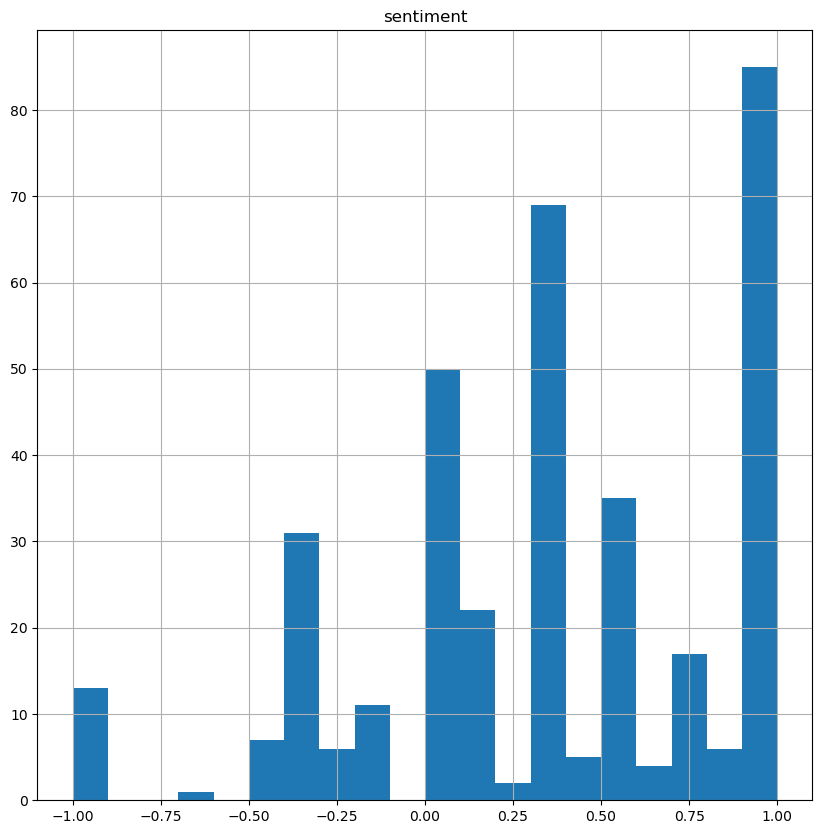

In [ ]:
old_tweets_avg.hist(bins=20, figsize=(10, 10))

##### Save the average sentiment dataframe

In [ ]:
old_tweets_avg.to_csv('old_tweets_average.csv')

##### Load the average sentiment dataframe

In [ ]:
old_tweets_avg = pd.read_csv('old_tweets_average.csv')
display(old_tweets_avg.head())

,Date,sentiment
0,2016-01-01,0.000000
1,2016-01-02,0.400000
2,2016-01-03,0.428571
3,2016-01-05,0.400000
4,2016-01-06,0.200000


### Load Yahoo Finance data for AAPL

In [ ]:
import yfinance as yf

In [ ]:

START = "2016-01-01"
END = "2017-12-31"
aapl = yf.download('AAPL', start = START, end = END)
djia = yf.download('^DJI', start = START, end = END)

print(aapl.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2016-01-04  25.652500  26.342501  25.500000  26.337500  24.074743  270597600
2016-01-05  26.437500  26.462500  25.602501  25.677500  23.471445  223164000
2016-01-06  25.139999  25.592501  24.967501  25.174999  23.012114  273829600
2016-01-07  24.670000  25.032499  24.107500  24.112499  22.040899  324377600
2016-01-08  24.637501  24.777500  24.190001  24.240000  22.157448  283192000


In [ ]:
aapl['PriceDiff'] = aapl['Adj Close'].shift(-1) - aapl['Adj Close']
aapl['PriceDiff'].dropna(inplace=True)

djia['PriceDiff'] = djia['Adj Close'].shift(-1) - djia['Adj Close']
djia['PriceDiff'].dropna(inplace=True)


In [ ]:
# Save AAPL_PriceDiff file 
aapl['PriceDiff'].to_csv('YahooFinance/AAPL_PriceDiff.csv')

# Load AAPL_PriceDiff file 
aapl_price_diff = pd.read_csv('YahooFinance/AAPL_PriceDiff.csv')
display(aapl_price_diff.head())

,Date,PriceDiff
0,2016-01-04,-0.603298
1,2016-01-05,-0.459332
2,2016-01-06,-0.971214
3,2016-01-07,0.116549
4,2016-01-08,0.358774


In [ ]:
# Save DJIA_PriceDiff file 
djia['PriceDiff'].to_csv('YahooFinance/DJIA_PriceDiff.csv')

# Load DJIA_PriceDiff file 
djia_price_diff = pd.read_csv('YahooFinance/DJIA_PriceDiff.csv')
display(djia_price_diff.head())

,Date,PriceDiff
0,2016-01-04,9.720703
1,2016-01-05,-252.150391
2,2016-01-06,-392.410156
3,2016-01-07,-167.649414
4,2016-01-08,52.120117


In [ ]:
stock_prediction_df = pd.merge(old_tweets_avg, aapl_price_diff, left_on='Date', right_on='Date', how='inner')
display(stock_prediction_df.head())

,Date,sentiment,PriceDiff
0,2016-01-05,0.400000,-0.459332
1,2016-01-06,0.200000,-0.971214
2,2016-01-07,0.111111,0.116549
3,2016-01-08,0.400000,0.358774
4,2016-01-11,0.400000,0.326786


#### Save the stock_prediction dataframe

In [ ]:
stock_prediction_df.to_csv('stock_prediction.csv')

#### Load the stock_prediction dataframe

In [ ]:
stock_prediction_df = pd.read_csv('stock_prediction.csv')
stock_prediction_df.set_index('Date', inplace=True)
stock_prediction_df.drop(columns=['Unnamed: 0'],inplace=True)

In [ ]:
display(stock_prediction_df.head())

,sentiment,PriceDiff
Date,,
2016-01-05,0.400000,-0.459332
2016-01-06,0.200000,-0.971214
2016-01-07,0.111111,0.116549
2016-01-08,0.400000,0.358774
2016-01-11,0.400000,0.326786


#### Feature Engineering

##### Time Series Analysis

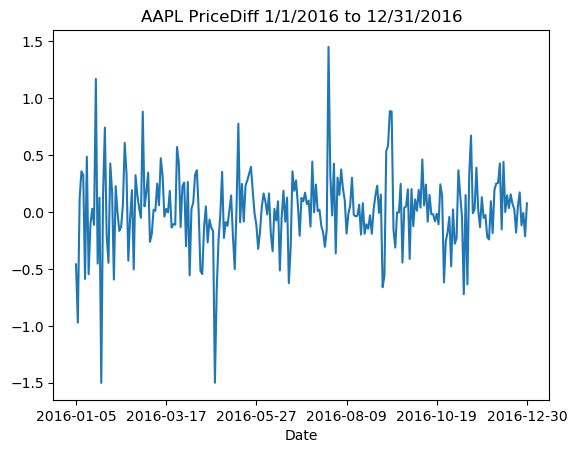

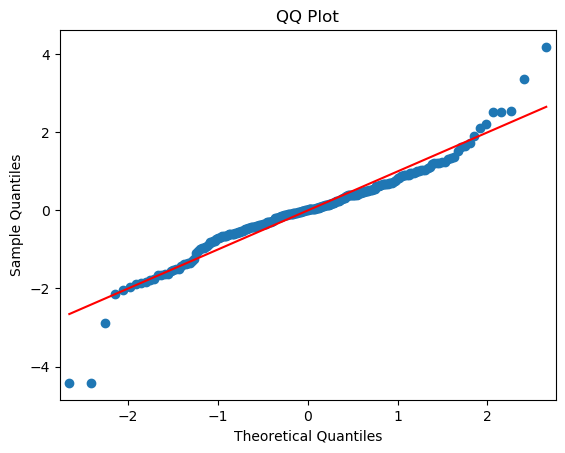

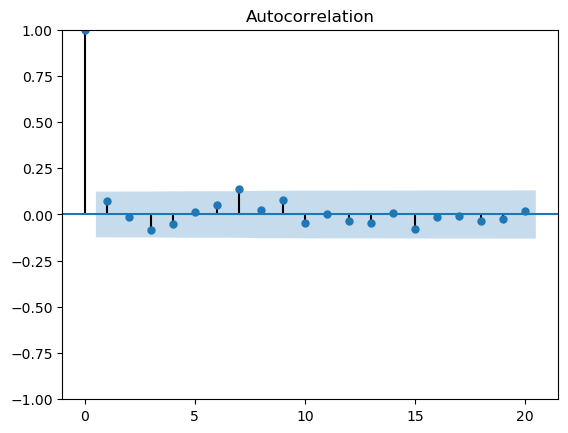

In [ ]:
#Calculate the price difference between consecutive days
stock_prediction_df['PriceDiff'].plot()
plt.title('AAPL PriceDiff 1/1/2016 to 12/31/2016')

fig = sm.qqplot(stock_prediction_df['PriceDiff'], fit = True, line='s') 
plt.title('QQ Plot')
plt.xlabel('Theoretical Quantiles') 
plt.ylabel('Sample Quantiles')
plt.show()

fig = sm.graphics.tsa.plot_acf(stock_prediction_df['PriceDiff'], lags=20)
plt.show()

Comment: There is significant autocovariance between PriceDiff and PriceDiff_lag_7

In [ ]:
# Create lagged features for the price_diff values
for i in range(1, 8):
    stock_prediction_df[f'PriceDiff_{i}'] = stock_prediction_df['PriceDiff'].shift(i)

# Remove missing values
stock_prediction_df.dropna(inplace=True)

In [ ]:
display(stock_prediction_df.head())

,sentiment,PriceDiff,PriceDiff_1,PriceDiff_2,PriceDiff_3,PriceDiff_4,PriceDiff_5,PriceDiff_6,PriceDiff_7
Date,,,,,,,,,
2016-01-14,0.20,-0.546164,0.486752,-0.587301,0.326786,0.358774,0.116549,-0.971214,-0.459332
2016-01-15,0.75,-0.107405,-0.546164,0.486752,-0.587301,0.326786,0.358774,0.116549,-0.971214
2016-01-19,0.50,0.029707,-0.107405,-0.546164,0.486752,-0.587301,0.326786,0.358774,0.116549
2016-01-20,0.80,-0.111977,0.029707,-0.107405,-0.546164,0.486752,-0.587301,0.326786,0.358774
2016-01-21,0.20,1.170027,-0.111977,0.029707,-0.107405,-0.546164,0.486752,-0.587301,0.326786


##### Train test split

In [ ]:
stock_X = stock_prediction_df[['sentiment']]
# stock_X = stock_prediction_df[['sentiment', 'PriceDiff_1', 'PriceDiff_2', 'PriceDiff_3', 'PriceDiff_4', 'PriceDiff_5', 'PriceDiff_6', 'PriceDiff_7']]
#convert string dates to float
# stock_X['Date'] = stock_X['Date'].str.replace(r'-', '')
# stock_X['Date'] = pd.to_numeric(stock_X['Date'],errors='coerce')
stock_Y = stock_prediction_df.PriceDiff
# X_train, X_test, y_train, y_test = train_test_split(stock_X, stock_Y,random_state=1,test_size=0.3,shuffle=False)
X_train = stock_X.loc[:"2016-08-31"]
y_train = stock_Y.loc[:"2016-08-31"]
X_test = stock_X.loc["2016-09-01":]
y_test = stock_Y.loc["2016-09-01":]

#### Train Boosted Regression Tree

In [341]:
reg_model = GradientBoostingRegressor(random_state=0)
reg_model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=0)

##### Load and save the model

In [342]:
#save the model to models/
filename = 'models/reg_model.sav'
pickle.dump(reg_model, open(filename, 'wb'))

# load the model from models/
reg_model = pickle.load(open(filename, 'rb'))

In [343]:
y_pred_reg = reg_model.predict(X_test)
y_pred_reg_stock_X = reg_model.predict(stock_X)

In [344]:
stock_prediction_df['PriceDiff predicted GBM'] = y_pred_reg_stock_X
display(stock_prediction_df.head())

,sentiment,PriceDiff,PriceDiff_1,PriceDiff_2,PriceDiff_3,PriceDiff_4,PriceDiff_5,PriceDiff_6,PriceDiff_7,PriceDiff predicted GBM,PriceDiff predicted MLP
Date,,,,,,,,,,,
2016-01-14,0.20,-0.546164,0.486752,-0.587301,0.326786,0.358774,0.116549,-0.971214,-0.459332,-0.019528,0.019499
2016-01-15,0.75,-0.107405,-0.546164,0.486752,-0.587301,0.326786,0.358774,0.116549,-0.971214,-0.081513,0.052119
2016-01-19,0.50,0.029707,-0.107405,-0.546164,0.486752,-0.587301,0.326786,0.358774,0.116549,0.038834,0.037130
2016-01-20,0.80,-0.111977,0.029707,-0.107405,-0.546164,0.486752,-0.587301,0.326786,0.358774,-0.087475,0.055117
2016-01-21,0.20,1.170027,-0.111977,0.029707,-0.107405,-0.546164,0.486752,-0.587301,0.326786,-0.019528,0.019499


##### Plot the two stock market predictions

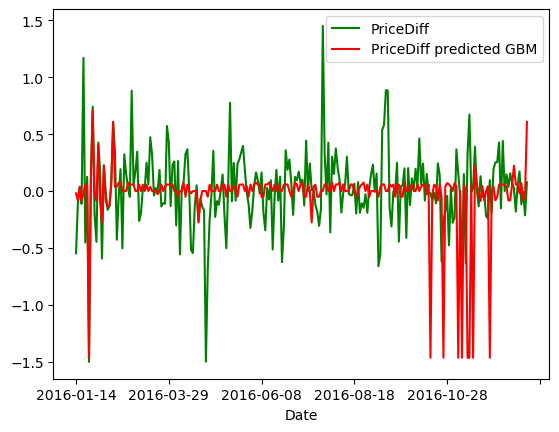

In [366]:
ax = plt.gca()
stock_prediction_df.plot(y='PriceDiff',color='green',ax=ax)
stock_prediction_df.plot(y='PriceDiff predicted GBM',color='red',ax=ax)
plt.savefig('../Charts/stock_prediction_aapl_gbm.png')

In [346]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred_reg)
mae = mean_absolute_error(y_test, y_pred_reg)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_reg)
print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R-squared: {r2:.2f}')

Mean Squared Error: 0.31
Mean Absolute Error: 0.35
Root Mean Squared Error: 0.56
R-squared: -2.40


#### Train MLP model

In [347]:
mlp_model = MLPRegressor(hidden_layer_sizes=5, max_iter=2000, random_state=0)
mlp_model.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=5, max_iter=2000, random_state=0)

In [348]:
#save the model to models/
filename = 'models/mlp_model.sav'
pickle.dump(mlp_model, open(filename, 'wb'))

# load the model from models/
mlp_model = pickle.load(open(filename, 'rb'))

In [349]:
y_pred_mlp= mlp_model.predict(X_test)
y_pred_mlp_stock_X = mlp_model.predict(stock_X)

In [350]:
stock_prediction_df['PriceDiff predicted MLP'] = y_pred_mlp_stock_X
display(stock_prediction_df.head())

,sentiment,PriceDiff,PriceDiff_1,PriceDiff_2,PriceDiff_3,PriceDiff_4,PriceDiff_5,PriceDiff_6,PriceDiff_7,PriceDiff predicted GBM,PriceDiff predicted MLP
Date,,,,,,,,,,,
2016-01-14,0.20,-0.546164,0.486752,-0.587301,0.326786,0.358774,0.116549,-0.971214,-0.459332,-0.019528,0.019499
2016-01-15,0.75,-0.107405,-0.546164,0.486752,-0.587301,0.326786,0.358774,0.116549,-0.971214,-0.081513,0.052119
2016-01-19,0.50,0.029707,-0.107405,-0.546164,0.486752,-0.587301,0.326786,0.358774,0.116549,0.038834,0.037130
2016-01-20,0.80,-0.111977,0.029707,-0.107405,-0.546164,0.486752,-0.587301,0.326786,0.358774,-0.087475,0.055117
2016-01-21,0.20,1.170027,-0.111977,0.029707,-0.107405,-0.546164,0.486752,-0.587301,0.326786,-0.019528,0.019499


##### Plot the two stock market predictions

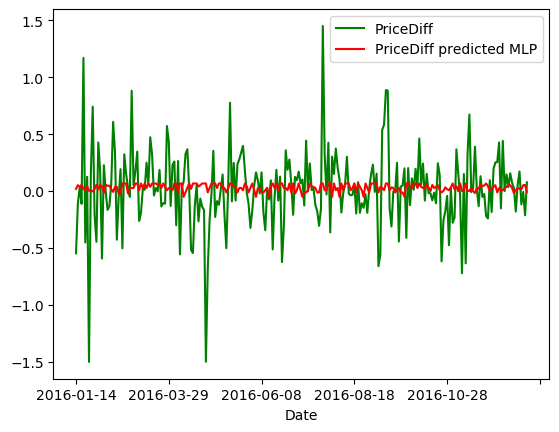

In [365]:
ax = plt.gca()
stock_prediction_df.plot(y='PriceDiff',color='green',ax=ax)
stock_prediction_df.plot(y='PriceDiff predicted MLP',color='red',ax=ax)
plt.savefig('../Charts/stock_prediction_aapl_mlp.png')

In [352]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred_mlp)
mae = mean_absolute_error(y_test, y_pred_mlp)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_mlp)
print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R-squared: {r2:.2f}')

Mean Squared Error: 0.09
Mean Absolute Error: 0.22
Root Mean Squared Error: 0.30
R-squared: 0.01


#### Compare Both Models

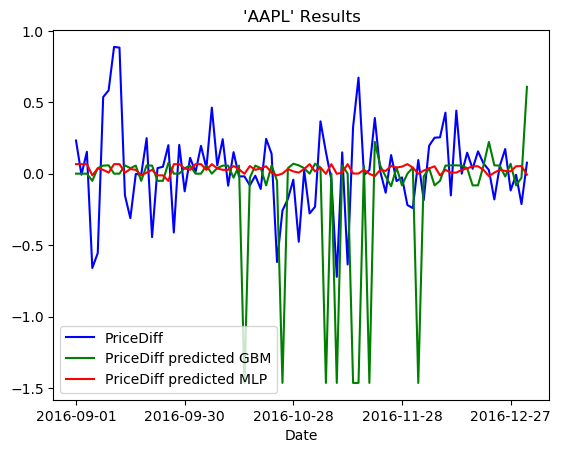

In [367]:
ax = plt.gca()
stock_prediction_df.loc['2016-09-01':].plot(y='PriceDiff',color='blue',ax=ax)
stock_prediction_df.loc['2016-09-01':].plot(y='PriceDiff predicted GBM',color='green',ax=ax)
stock_prediction_df.loc['2016-09-01':].plot(y='PriceDiff predicted MLP',color='red',ax=ax)
ax.set_title("'AAPL' Results")
plt.savefig('../Charts/stock_prediction_aapl_comparison.png')

#### Save the final stock_prediction_df 

In [361]:
stock_prediction_df.to_csv('final.csv')

In [ ]:
#### 